![Musicbox-Transformer image, via Stable Diffusion XL](images/musicbox_prime.jpeg)

In [ ]:
#| echo: false
from IPython.display import display, HTML
# lil bit of added color 
HTML("""<style>
details > summary {
    color: #00966f;   /* the greenish tinge that appears in my blog */
    cursor: pointer; /* lil triangle thingy */
}
</style>
""")

# Preface
This is a follow-up to an earlier lesson, ["To Understand Transformers, Focus on Attention"](https://drscotthawley.github.io/blog/posts/Transformers1-Attention.html).  In this lesson, we'll fill the  "blanks" we left in the Transformer architecture last time, and go on to build a working example.  

For that example, let's do something different from the many other online lessons about working with text & Natural Language Processing (NLP): Let's make a "Generative Music Transformer." To keep things "small," we'll work in terms of MIDI instead of raw audio. For ideas about trying raw audio, see "Further Study" in @sec-further.

::: {.callout-note}
The goal of this exercise is building *some understanding*, not building a killer MIDI-generating app. If you want the latter, check out [Google Magenta's paper](https://magenta.tensorflow.org/music-transformer) from 2018, or various extensions since then. If you just want to play around with a great MIDI model, check out [SkyTNT's HuggingFace Space](https://huggingface.co/spaces/skytnt/midi-composer). By "some" understanding, I also mean that we're going to largely ignore the many, many variants and improvements on Transformers made over the past several years -- lately ["Mamba"](https://arxiv.org/abs/2312.00752) is generating consierable buzz.  I find that [Sebastian Raschka](https://twitter.com/rasbt)'s posts to be helpful for considering major updates on the Transformer "theme". 
:::


## Managing Expectations

What we'll end up with is something akin to [producing garbled Shakespeare](https://www.youtube.com/watch?v=kCc8FmEb1nY), except it's going to be musical. Garbled music seems much harder to tolerate than garbled Shakespeare, which is why I have delayed releasing this lesson for *multiple months* -- I've kept trying to get better results. At this point, I'm resigned to the fact that *this is a hard problem* (even for MIDI!), and my current outputs are about "as good as they're going to get":

<blockquote class="twitter-tweet tw-align-center"><p lang="en" dir="ltr">It&#39;s way harder to train a simple MIDI transformer to sound OK than a next-character GPT-type transformer to create text that makes at least basic sense. MIDI tokenizer choice is a big deal here also.</p>&mdash; Mateusz Modrzejewski (\@mamodrzejewski) <a href="https://twitter.com/mamodrzejewski/status/1728858756736557451?ref_src=twsrc%5Etfw">November 26, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

...and we're going to keep the tokenizer simple.


-- [Scott H. Hawley](https://hedges.belmont.edu), December 2023


::: {.callout-note}
In what follows, I've often put sections and subsections in expandable "Details" blocks, to enable readers to pick and choose the level of depth they want to see. Enjoy! 
:::

---

# Intuiting the Rest of the Transformer



The [previous lesson](https://drscotthawley.github.io/blog/posts/Transformers1-Attention.html) left some things out.  In this section, we'll build some intuitive understanding of these other components, and a bit of code.  

Below is a picture of the original Transformer model diagram, whose parts we will elucide as we go on. It's 
set up like the traditional ["encoder-decoder" architecture](https://tex.stackexchange.com/questions/374926/drawing-an-encoder-decoder-architecture-in-tikz) one often sees in the form of an ["hourglass shape"](images/EncoderDecoder_feedback_large.png), although it may not be obvious from the Transformer diagram:


<style>
.img1 {
    /*transform-origin: top left;*/
    width:450px;
    transition:transform 0.4s ease;
    position: relative;
    z-index: 0;
}
.img1:hover {
    -webkit-transform:scale(1.7);
    transform:scale(1.7);
    z-index:1;
}
</style>

::: {#fig-trans-diag}

![](images/TransformerSchematic_labeled.png){.img1} 

(Mouse-over or press to expand.) Original Transformer architecture illustration, blue and red annotations added by me. The "Encoder side" in red is often used for generating embeddings for analysis-based workflows such as classification tasks; one of which  of the most famous 'encoder-only' models was BERT (which stood Bidirectional Encoder Representations from Transformers). 
:::
For langauge translation tasks, both the Encoder and Decoder (circled in blue) are used. For purely "generative" systems like the GPT variants and what we'll do today, we'll use the Decoder side. Note however that even the Decoder can involve some encoding, as we combine an embedding of the words / MIDI / "tokens" with Positional Encoding information. PE is discussed below. 

We're going to go through the various components that make up the above diagram. But first, let's point out something about the Attention mechanism that we skipped over in the previous less, namely the computational "cost" associated with making every part of a sequence with every other part. 

## The Cost of Attention

The attention mechanism *per se* that we covered in the previous post has a serious drawback: the computational cost scales like the sequence length squared, i.e. for a sequence length of $N$, the cost is
 <big>𝒪</big>($N^2)$.  This is one reason that Large Language Models can be "Large" -- trying to model long sequences results in big matrices!
 
<details><summary>Details</summary>



    

Various schemes have been proposed to reduce this cost, such as only applying attention over nearby tokens (so-called "sliding window" attention) or other methods that fall under the general heading of "matrix sparsification". Here's a slide from a talk I gave a few years ago, illustrating a few of these schemes:

::: {#fig-attn-cost}

![](images/attention_cost.hawley.png)

Various schemes for reducing the <big>𝒪</big>($N^2)$ cost of Attention. Many such schemes involve replacing the `Linear` layers with convolution operations, such as with the local receptive fields shown in b) and c).  (Source: S.H. Hawley, ["Learning Tunable Audio Effects via Neural Networks with Self-Attention"](https://hedges.belmont.edu/AES_ML_2020/), AES Virtual Symposium: Applications of Machine Learning in Audio, Sep 28, 2020.)

:::

For this lesson, we'll see how far we can get with the basic $N^2$ attention. Beyond that, I encourage you to check the literature for whatever the latest/hottest cost-reducing model might be. Popular candidates include [FlashAttention](https://arxiv.org/abs/2205.14135) and [PercieverIO](https://arxiv.org/abs/2107.14795). Even sliding windows are [still in use in ways that some people find significant](https://twitter.com/hrishioa/status/1712199009308398079).

## Positional Encoding (aka Positional Embeddings)

MLPs and/or ConvNets don't come with (much of) a sense of position, but giving them one can improve performance on tasks where ordering and position matters. There many ways people have have endowed such models with position-awareness and... TBH there's not necessarily a "silver bullet" solution, so a variety of approaches can end up performing about the same. In what follows we'll describe various schemes for doing PEs. 

<details><summary>Details on PEs</summary>


### Some Options for PEs

1. You could just concatenate a "linear ramp" of values to provide some position values, but... you wouldn't want to do that. You won't get very good gradients, especially for long sequences.

2. There's the orignal positional encoding from the [AIAYN](https://arxiv.org/abs/1706.03762) paper, which uses a set of sines & cosines of expontially-increasing wavelength. They tweaked these wavelengths for their use case and ended up with
the following  equations:
$$
\begin{aligned}
PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{model}}) \\
PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{model}})
\end{aligned}
$$
But the authors of the Transformer paper said they tried a few different PE methods/equations -- including letting the model learn the PEs -- but found no significant impact on performance between them. So let's add that to list, btw:

3. You could **let the positional embeddings be learned** via some trainable mapping.  *This* is the approach that Karpathy uses in his mini-GPT tutorial, and it's the approach we'll use in this lesson as well.

4. [Francois Fleuret](https://fleuret.org/francois/) in his ["AttentionToy1D"](https://twitter.com/francoisfleuret/status/1262639062785105922) demo, used a simplification of approach #2 by essentially turning it into a set of <a href="images/fleuret_binary.png">binary sequences</a> that correspond to the vertices of a hypercube.

5. ["ALiBi" (Attention with Linear Biases)](https://arxiv.org/abs/2108.12409) is a method whereby you don't do positional encoding of the inputs, rather you insert the positional information into the attention calculation itself. It is *slightly* faster to execute than traditional PE and (probably?) offers less memory overhead, and yields comparable results. (I tried it, it didn't make any difference so I left it out of htis lesson.)
   
7. One scheme, "[Relative Position Embeddings](https://paperswithcode.com/method/relative-position-encodings)," was reported to make a big difference and it arose in the [Music Transformer](https://arxiv.org/abs/1809.04281) paper itself.  Are we going to do that?  ...Uh....no, but that would be a great exercise for a student. 


### PEs: To Add or Concatenate?
Here's a design question: Should we add these PEs to our inputs or concatenate them? 

TODO: revise this. 

That's debateable, and it depends. [Here's a great video discussing this topic](https://www.youtube.com/watch?v=M2ToEXF6Olw). If the number of PE channels is less than the number of input channels (or input embedding dimensions), then we'll definitely need to concatenate the PEs as additional channels for the inputs.  That's what Fleuret did when he was working with only one channel of floating point inputs, BTW. Here's some code we'll use later to concatenate the PEs to our data sequences.


</details> 
::: {.callout-tip}

A great source of instruction about all things related to Positional Encodings is the YouTube channel, 
["AI Coffee Break with Letitia"](https://www.youtube.com/@AICoffeeBreak). 
:::



## Residual Connections
In the Transfomer model diagram  of @fig-trans-diag, wherever you see arrows going *around* something and connecting to a yellow "Add & Norm" block, that is indicative of a "skip residual" or just "residual" connection.  Readers will likely have seen residual / skip connections in other contexts, so we'll make this section "Details"-expandable for those who haven't encountered them.

<details><summary>Details</summary>


This is a pretty simple idea that yields payoffs in many areas of numerical modeling: You model the *change* in something instead of modeling the whole thing. The following flowchart illustrates this:


::: {#fig-resid}
<div style="background-color:white; width: 65%; margin-left: auto; margin-right: auto;">
<img src = "https://mermaid.ink/svg/pako:eNo1j0EKg0AMRa8yBAQFewEXBaubQruxu5JNcGIVnIyMGUqR3r3TSnf_fR4kf4PeW4YKhtk_-5GCmkuHkmVG_WLsRI9ADqXOz7JELczhcDzljXcJ2DQjyYMLlNO3N01eW5uo3gml-YU273iNsxZQguPgaLLp3oZiDIKO7BihStHyQElDQHknlaL620t6qDRELiEulpTb_aN_yXZSH677hN-SEhaSu_dJGWhe-f0B3txJZw">
</div>

Flowchart of a residual connection

:::


With neural networks, this residual scheme has the added benefit of allowing for efficient backpropagation. There are claims that "skip residual" connections also help smooth the loss surface, such as [this figure in a N(eur)IPS paper from 2017](https://arxiv.org/abs/1712.09913):

::: {#fig-loss-landscape}

![](https://miro.medium.com/v2/resize:fit:723/1*_Qd_txKxRlsMdfuH2J-k4g.png)

Loss landscape picture purporting to show the "smoothing" effects of residual connections. (Source: [Li et al](https://arxiv.org/abs/1712.09913).)  

:::

##  Multi-Head Attention

As described in the previous lesson, Multi-Head Attention simply involves allowing differently-weighted attention operators (called "heads") to perform attention operations, allowing them to focus on different "senses" of phrases, parts of speech, or in our case, musical structures. 


<style>
.img-mh {
    /*transform-origin: top left;*/
    width:250px;
    transition:transform 0.4s ease;
    position: relative;
    z-index: 0;
}
.img-mh:hover {
    -webkit-transform:scale(1.7);
    transform:scale(1.7);
    z-index:1;
}
</style>

::: {#fig-mh-attn}

![](https://machinelearningmastery.com/wp-content/uploads/2021/09/tour_4.png){.img-mh}

Diagram of Multi-Head Attention. The multiple attention "heads" are shown below as depthwise semi-transparent copies, which are then concatenated into "one big long thing" via the Concat operation, and then mapped into the the output for the module via the last Linear layer: (Source: [AIAYN](https://arxiv.org/abs/1706.03762).)
:::

## Layer Normalization

This alternative to [Batch Normalization](https://paperswithcode.com/method/batch-normalization) (in which we perform elementwise operations where we subtract the mean across the batch dimension and divide by the variance).  Instead of doing this across the batch dimension, we do it across the feature dimension(s).


<style>
.img-ln {
    /*transform-origin: top left;*/
    width:350px;
    transition:transform 0.4s ease;
    position: relative;
    z-index: 0;
}
.img-ln:hover {
    -webkit-transform:scale(1.7);
    transform:scale(1.7);
    z-index:1;
}
</style>

::: {#fig-norm-types}
![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png){.img-ln}

(Mouse-over or press to expand.) Batch normalization  vs. Layer normalization. (Source: [PapersWithCode](https://paperswithcode.com/method/layer-normalization).)
:::

One big advantage of doing our normalization across layers instead of batches is that *it allows for small batch sizes.*  Language models are often *large*, so they take up a lot of memory, which means you might need very small batches. But small batches will not allow you to do very good batch normalization. So, LayerNorm helps us get good statistics for the mean and variance that we use to normalize.


## Stacking Blocks: Embeddings of Embeddings...of Embeddings

By stacking layers of our transformers, i.e. feeding embeddings into layers that will render them as new embeddings, we wil increase the representational power of our model.  In terms of code, this is easy to do by looping over a list of layers.



# The Music (MIDI) Dataset

This section adopts a first-person perspective because I want to convey a personal tone:  I confess that I'm "not a MIDI guy," having always worked with raw audio exclusively.  I vastly underestimated how difficult it would be to get decent results. Starting from Google's well-known [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro) of solo piano performances -- NOTE: *virtuoso* piano performances! --I kept downgrading the "difficulty" of the dataset until settling on [Bach chorales](https://github.com/czhuang/JSB-Chorales-dataset). 

    
  

## Learning About MIDI Data

<details><summary>Details</summary>

The MAESTRO data wasn't overly challenging if I only focussed on modeling the pitches, but music is pitch + timing (+ more). What's more, I'd only ever seen MIDI music "quantized" into a grid-based "piano roll" format with a known time-signature, not realizing that that's not what MIDI data really is. For our purposes, it's worth noting that MIDI encodes several pieces of information on a *per-note* basis:

1. What instrument played the note
2. What pitch was played -- an integer between 0 and 127.
3. The start time of the note -- in units of the "MIDI clock" which  *usually* ticks at 50,000 times a second. This is typically rendered as a floating-point number when using Python MIDI-processing packages such as Colin Raffel's [pretty-midi](https://craffel.github.io/pretty-midi/) (which we will use)
4. The end time of the note - another float.
5. The "velocity" of the note -- e.g. how hard a piano key was struck. 

So, no time signature, no quarter-note, half-note, etc.  But fine, taking a lead from the [Google Tensorflow Demo for RNN Modeling](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb), we can reduce each note to 3 numbers: 
1. pitch
2. "step" in time since the previous note
3. duration of the note (i.e. end time minus start time). 

...and focus on single-instrument work, and disregard the velocity. 

EVEN THAT was too hard for the code below do with MAESTRO. I then noticed a [paper by the Google team](https://arxiv.org/abs/1808.03715) pointed out that quantizing the time into bins of 8 milliseconds was an ok simplification to make, but even this proved too hard for my model. (I could do 16 ms, but that sounded weird.)

...so....  after surveying other things, I went with [Bach Chorales](https://github.com/czhuang/JSB-Chorales-dataset), which actually *are* presented in piano-roll format quantized to 16th note time intervals. Then I had to convert those from JSON to true MIDI, because by then the rest of my code expected MIDI. 

I'll spare you the details of that process, but note that the data link below is not the official dataset link, it's [my private stash](https://drive.google.com/file/d/1MdJiNEgtkvCx9tnyQWcnEE5GPMY6ADUb/view?usp=sharing) where I converted the JSON to .mid. 

## Install and Import

In [ ]:
#| code-fold: true
#| code-summary: "Show the code for system-wide installs"
#| output: false
#| error: false
#| warning: false

import platform
import os

def install_package(package_name):
    "For installing system binaries on Linux (Ubuntu/Debia) or Mac (via Homebrew)"
    if platform.system() == 'Darwin':
        os.system(f'brew install {package_name}')
    elif platform.system() == 'Linux':
        import getpass  # TODO: colab doesn't need a password for sudo
        password = getpass.getpass()
        command = f"sudo -S apt-get install {package_name}" 
        os.popen(command, 'w').write(password+'\n')
    else:
        print("Unsupported Operating System")

# skip it for now
#install_package('fluidsynth')


In [ ]:
#| code-fold: true
#| code-summary: "Show the code for pip installs"

!pip install -qq gdown pyfluidsynth pretty_midi torch numpy pandas midi-player multiprocess

In [ ]:
#| code-fold: true
#| code-summary: "Show the code for imports"


# import (most of) what we'll need for the entire lesson
import collections
import datetime
import fluidsynth
import glob
import pandas as pd
import pretty_midi

import torch
from torch import nn, einsum
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from typing import Optional
from glob import glob
from pathlib import Path

import multiprocess as mp   # multiprocess is a Jupyter-compatible fork of multiprocessing
from functools import partial

from tqdm import tqdm  # note: Quarto blog won't print output from tqdm.notebook
#from tqdm.contrib.concurrent import process_map  # process_map throws errors on Mac :'-( 

import random
import numpy as np 
import pprint


## Download and Inspect the Data

In [ ]:
#| code-fold: true
#| code-summary: "Show the code for downloading the dataset"

# Get the data
data_source = 'jsb_chorales_midi'
# TODO: add options for MAESTRO, others

data_dir = Path('midi_data') # generic name for whatever midi we might want
REST_PITCH = 127  # special code  used to denote rests

!gdown -O {data_source}.tgz 1MdJiNEgtkvCx9tnyQWcnEE5GPMY6ADUb
!tar zxf {data_source}.tgz; rm -rf midi_data; ln -s {data_source} midi_data ;

# get the list of MIDI filenames
filenames = sorted(glob(str(data_dir/'**/*.mid*'),recursive=True))
print('Number of files:', len(filenames))

Downloading...
From: https://drive.google.com/uc?id=1MdJiNEgtkvCx9tnyQWcnEE5GPMY6ADUb
To: /Users/shawley/github/blog/posts/jsb_chorales_midi.tgz
100%|█████████████████████████████████████████| 137k/137k [00:00<00:00, 113MB/s]
Number of files: 382


Let's inspect one of the files --  using the [`MIDIPlayer`](https://github.com/drscotthawley/midi-player)  object created especially for this lesson!

In [ ]:
#| code-fold: true
#| code-summary: "Show the code for MIDI player usage"
#| label: fig-midi-play1
#| fig-cap: Example of the first MIDI file on our list. (Press the play button to listen.)  These particular notes really *were* arranged on a "grid," however I converted them to a series of MIDI "notes," occurring one after the other in the file, with simultaneously-starting notes sorted in ascending order of pitch.

from midi_player import MIDIPlayer
from midi_player.stylers import general, dark # I like dark mode

midi_file = filenames[0]
MIDIPlayer(midi_file, 360, styler=dark, title=f"midi_file = {midi_file}")

::: {.callout-note}
Sometimes the `MIDIPlayer`'s piano roll view will appear blank if the notes are below the bottom of the visible frame. Scroll downward inside the player to reveal all the notes.  The piano roll also scrolls left & right. 
:::


Let's load a single file and convert it to a PyTorch tensor called `notes_tensor`, and we'll go ahead and convert "start" and "end" times "step" and "duration" times. So, displaying the first several notes (using a `pandas` dataframe for style) we see...

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: tbl-firstnotes
#| tbl-cap: "First 8 notes of `notes_tensor`"

def quantize_times(times, 
                   res_ms=8, # resolution in milliseconds. 8ms was deemed sufficient for MAESTRO.
                   clamp_range_s=[0.0,4.0]):
    quant_step = res_ms / 1000.0
    q_times = torch.round(times / quant_step) * quant_step
    if clamp_range_s is not None: 
        q_times = torch.clamp(q_times, clamp_range_s[0], clamp_range_s[1])
    return q_times

def midi_file_to_tensor(filenames, i=None, keep_start_end=False, rest_pitches=[REST_PITCH]):  # filenames could just be a single filename
    midi_file = filenames if i is None or type(filenames)==str  else filenames[i]
    "reads a single midi file and converts it to tensor with elements (pitch, step, duration)"
    pm = pretty_midi.PrettyMIDI(midi_file) # read in the whole file. this can be very slow for long MIDI files (e.g. in MAESTRO)

    # Sort the notes first by start time (and then by pitch if two notes start at the same time)
    sorted_notes = sorted(pm.instruments[0].notes, key=lambda note: (note.start, note.pitch))
    #notes = torch.empty( (len(sorted_notes), 3 + 2*keep_start_end), dtype=torch.float32 ) # allocate storage
    
    prev_start = sorted_notes[0].start
    notes = []
    for i, note in enumerate(sorted_notes):
        new_note =  torch.empty( (3 + 2*keep_start_end) , dtype=torch.float32)
        if int(note.pitch) in rest_pitches: continue  # we can actually delete the rests! 
        new_note[0] = note.pitch
        new_note[1] = note.start - prev_start  # step, i.e. time since start of previous note
        new_note[2] = note.end - note.start    # duration
        if keep_start_end:                     # might find it useful be able to keep these for easier analysis later
            new_note[3] = note.start
            new_note[4] = note.end
        prev_start = note.start
        notes.append(new_note)

    notes = torch.vstack(notes)
    notes[:,1:] = quantize_times(notes[:,1:])
    return notes

notes_tensor = midi_file_to_tensor(midi_file)
pd.set_option('display.notebook_repr_html', True)
notes_df = pd.DataFrame(notes_tensor, columns=['pitch','step','duration']) # actually df's look nicer


# making it look better in the blog: adjust width of pandas dataframes
display(HTML('''
<style>
.dataframe {
    width: 40%; /* Adjust this value as needed */
    margin-left: auto;
    margin-right: auto;
}
.dataframe th, .dataframe td {
    text-align: center;
    width: auto !important;
}

table {
    margin-left: auto;
    margin-right: auto;
}
th, td {
    text-align: center;
    min-width: 100px; /* Or any other width */
}
</style>
'''))
HTML(notes_df[:8].to_html(index=False))

pitch,step,duration
53.0,0.00,0.48
57.0,0.00,0.48
60.0,0.00,1.44
65.0,0.00,0.48
52.0,0.48,0.48
55.0,0.00,0.48
72.0,0.00,0.24
70.0,0.24,0.24


We'll convert those floating point numbers to integers via the "tokenizer" below. 

Now we'll load each song into an entry in a list called `notes_tensor_list`:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"


def files_to_tensor_list(filenames, keep_start_end=False, serial=True):
    "Reads MIDI files in parallel so should be reasonably fast. JSB Chorales are no prob but for MAESTRO you want this"
    # tensor_list = process_map(midi_file_to_tensor, filenames, max_workers=mp.cpu_count(), chunksize=1) # Doesn't work on Mac
    tensor_list = []
    max_ = len(filenames)
    if serial:
        for i, filename in enumerate(tqdm(filenames)):
            tensor_list.append(midi_file_to_tensor(filename,  keep_start_end=keep_start_end))
    else:
        with mp.Pool(processes=mp.cpu_count()) as p:
            with tqdm(total=max_) as pbar:
                for r in p.imap_unordered(partial(midi_file_to_tensor, filenames, keep_start_end=keep_start_end), range(0, max_)):
                    tensor_list.append(r)
                    pbar.update()
    return  tensor_list




notes_tensor_list_filename = f'{data_source}_tensor_list.pt'         # we'll save the result to a file for easier re-reading next time
read_all_midi_files = True # not os.path.exists(notes_tensor_list_filename) # check to see if it already exists

if read_all_midi_files:
    notes_tensor_list = files_to_tensor_list(filenames, serial=True)
    torch.save(notes_tensor_list, notes_tensor_list_filename) # save for next time
else:
    notes_tensor_list = torch.load(notes_tensor_list_filename) # just read from the last time we made one
    
print(f"\nlen(notes_tensor_list) = {len(notes_tensor_list)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:02<00:00, 155.96it/s]


len(notes_tensor_list) = 382


Also, let's make a single tensor `all_notes` out of all the notes. We're only going to use this for analysis purposes; for everything else we'll use the `notes_tensor_list`, which...I'm now going to abbreviate as `notes_tl`

In [ ]:
notes_tl = notes_tensor_list
all_notes = torch.vstack(notes_tl).type(torch.float32)
print("all_notes.shape = ",all_notes.shape)

all_notes.shape =  torch.Size([78349, 3])


## Making a Tokenizer

Rather than try something sophisticated like calling [MidiTok](https://github.com/Natooz/MidiTok), we're going to treat this like a "char-level RNN" and just regard each note as a "parallel" group of 3 tokens (one token for pitch, step, and duration).  This means that we will need 3 "codebooks" that can encode & decode between true values and their tokens. 
<details><summary>Details</summary>


For the pitch values, it's pretty easy since there are up to 128 pitches. Probably they won't all be used, so we *could* limit the range of pitches, however, I'm going to want to do some pitch-bending data augmentation, so the pitch tokens will just be `int` versions of their `floats`, indices in a 128-dimensional space. 

For the timing -- which I don't plan to do any augmentation of -- we'll just write down what  unique values are present. These will form the "vocabularies" that we often see used in NLP settings. 

Oh, also: The timing values end up being *reaaalllly* long in some cases. Like, notes with 15 seconds in duration?  I'm going to go ahead an clamp those to a maximum value of 4 seconds. 

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

from collections import defaultdict 

def make_codebooks(all_notes, verbose=False):
    codebooks = []
    n_codebooks = all_notes.shape[-1] # should be 3
    for i in range(n_codebooks): 
        if i==0:  # i=0 means pitch
            cb_vals = torch.arange(128)  # just use all possible pitches 
        else:     # i!=0 means timing
            cb_vals = all_notes[:,i].unique().sort()[0] 
        if verbose: print(f"\n---\ncb {i}: cb_vals = {cb_vals}")
        codebooks.append({'encode':{np.round(k.item(),3): int(v) for v, k in enumerate(cb_vals)}, # codebooks go both ways
                          'decode':{int(v): k for v, k in enumerate(cb_vals)}})
        if verbose: print(f" cb {i}: cb keys = {codebooks[-1]['encode'].keys()}")
    return codebooks

all_notes[:,1:] = quantize_times(all_notes[:,1:])
codebooks = make_codebooks(all_notes)

vocab_sizes = [len(cb['encode']) for cb in codebooks]
display(HTML(f"vocab_sizes = {vocab_sizes}"))

# Just a nice way to display the codebooks in the blog post: 
df1 = pd.DataFrame( [[k,v] for k,v in codebooks[1]['encode'].items()], columns=['steps: value','steps: index'])
df2 = pd.DataFrame( [[k,v] for k,v in codebooks[2]['encode'].items()], columns=['durs: value','durs: index'])
display(HTML(f"Codebooks for steps & durs are {'' if df1.equals(df2) else 'not '}the same:"))

html1, html2 = df1.to_html(index=False),  df2.to_html(index=False)

# Combine HTML strings with a space in between
combined_html = f'''<div style="width: 100%; text-align: center;">
    <table style="margin-left: auto; margin-right: auto;"> <tr>
    <td style="vertical-align: top;">{html1}</td>
    <td style="width: 50px;"></td>
    <td style="vertical-align: top;">{html2}</td>
    </tr></table></div>'''

# Display the combined HTML
display(HTML(combined_html))



steps: value,steps: index
0.00,0
0.12,1
0.24,2
0.36,3
0.48,4
0.72,5
0.96,6
1.20,7
1.44,8
1.68,9


 Now we need routines to convert back and forth between values and codebook indices. We'll make a single function `remap_vals()` that can either go "forward" for encoding, or "backward" for decoding:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
def remap_vals(seq, encdec_str, dtype=torch.long):
    out = torch.zeros_like(seq, dtype=dtype)
    for cb in range(seq.shape[-1]): 
        dict_map = codebooks[cb][encdec_str]
        default_map = max(codebooks[cb][encdec_str].values())
        out[:,cb] = torch.tensor([dict_map.get(np.round(x.item(),3),default_map) for x in seq[:,cb]], dtype=dtype) # that np.round(,3) is good for avoiding KeyErrors
        #out[:,cb] = torch.tensor([dict_map[np.round(x.item(),3)] for x in seq[:,cb]], dtype=dtype)
    return out 

# We'll be calling these 'encode' and 'decode functions', which really just pull up the applicable part of the codebooks
encode = lambda s: remap_vals(s, 'encode')
decode = lambda s: remap_vals(s, 'decode', dtype=all_notes.dtype)


# And let's do a little test
midi_seq = all_notes[0:6].clone()
print("Before encoding, midi_seq =\n",midi_seq)
token_list = encode(midi_seq)
print("After encoding, token_list =\n",token_list)
return_seq = decode(token_list)
print("After decoding, return_seq =\n",return_seq)
assert torch.equal(midi_seq, return_seq), f"Oops. midi_seq={midi_seq}, but return_seq={return_seq}. Should be the same"


midi_seq[-1,-1] = 100.0  # give the last time a huge value to check that our mapper won't crash
token_list = encode(midi_seq) # if it doesn't crash, we're good
assert token_list[-1,-1] == list(codebooks[-1]['encode'].values())[-1], "Big value should have gotten the last spot in the last codebook"

print("Checks pass! :-)")

Before encoding, midi_seq =
 tensor([[53.0000,  0.0000,  0.4800],
        [57.0000,  0.0000,  0.4800],
        [60.0000,  0.0000,  1.4400],
        [65.0000,  0.0000,  0.4800],
        [52.0000,  0.4800,  0.4800],
        [55.0000,  0.0000,  0.4800]])
After encoding, token_list =
 tensor([[53,  0,  3],
        [57,  0,  3],
        [60,  0, 11],
        [65,  0,  3],
        [52,  4,  3],
        [55,  0,  3]])
After decoding, return_seq =
 tensor([[53.0000,  0.0000,  0.4800],
        [57.0000,  0.0000,  0.4800],
        [60.0000,  0.0000,  1.4400],
        [65.0000,  0.0000,  0.4800],
        [52.0000,  0.4800,  0.4800],
        [55.0000,  0.0000,  0.4800]])
Checks pass! :-)


### More Checks:

Before moving on, it's a good idea to double check: Can we really encode and decode an entire midi sequence? Let's write some more utility files.  Notably the `midiplayer()` routine which will allow us to play our PyTorch tensors directly in this notebook.

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

def get_startend(notes:torch.Tensor) -> torch.Tensor:
    "integrates (step,duration) timing pairs to recover (start,end) info. concats them as new columns"
    newnotes = torch.zeros((len(notes), 5), dtype=notes.dtype, device=notes.device)
    newnotes[:,:3] = notes[:,:3]
    prev_start = 0.0
    for i, note in enumerate(notes): 
        step, dur = note[1], note[2]
        start = step  + prev_start 
        end   = start + dur
        newnotes[i,3], newnotes[i,4] = start, end
        prev_start = start   
    return newnotes
    

def notes_to_midi(notes:torch.Tensor, 
                  time_rescale=None, 
                  out_file: str = '',
                  instrument_name: str = 'Acoustic Grand Piano',
                  velocity: int = 64,  # default loudness for all notes
                 ) -> pretty_midi.PrettyMIDI:
    notes = notes.clone() # just to avoid weird overwrites of memory addresses
    if notes.min() < 0.0:
      print("WARNING: You have negative pitches, steps or durations. Setting them to zero")
      notes = notes * (notes >= 0)
    if time_rescale is not None: # just added this because sometime I want to slow/speed up
        notes[:,1:] = notes[:,1:] *time_rescale
        
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    if notes.shape[-1] < 5: notes = get_startend(notes)
        
    notes = notes.cpu().numpy()
    prev_start = 0.0
    for note in notes: 
        pitch, start, end = int(note[0]), note[3], note[4] 
        midi_note = pretty_midi.Note( velocity=velocity, pitch=pitch, start=start, end=end, )
        instrument.notes.append(midi_note)
        prev_start = start   
        
    pm.instruments.append(instrument)
    if out_file: pm.write(out_file)
    return pm



def midiplayer(notes_tensor, height=400, time_rescale=None, midi_file="/tmp/tmp.mid", title='', styler=dark):
    "MIDIplayer that writes input tensor to temporary file"
    pm = notes_to_midi(notes_tensor, time_rescale=time_rescale, out_file=midi_file)
    return MIDIPlayer(midi_file, height, styler=dark, dl=True, title=title)

We're going to encode & decode, and write to a MIDI file, and play that midi file. Using the same file as above:

In [ ]:
midiplayer(decode(encode(midi_file_to_tensor(filenames[0]))), title='Encode-Decode Test')

Yay!  Moving on...

## Making PyTorch Dataset(s)

Our particular dataset already comes with a test/train/valid split in its subdirectores, so let's use that split.  We'll go ahead and re-load the files:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

# tensor lists
train_filenames = [x for x in filenames if '/train' in x]
val_filenames   = [x for x in filenames if '/val'   in x]
test_filenames  = [x for x in filenames if '/test'  in x]

train_notes_tl = files_to_tensor_list(train_filenames, serial=True)
val_notes_tl   = files_to_tensor_list(val_filenames, serial=True)
test_notes_tl  = files_to_tensor_list(test_filenames, serial=True)

for name, tl in zip(['train','val','test'],[train_notes_tl, val_notes_tl, test_notes_tl]):
    stack = torch.vstack(tl)
    print(f"{len(tl)} songs in {name}, {stack.shape[0]} notes")

100%|███████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 140.92it/s]

229 songs in train, 46660 notes
76 songs in val, 15052 notes
77 songs in test, 16637 notes


...that's not a ton of data. We should incude some data augmentation. 

### Data Augmentation

We'll augment the pitch values by raising & lowering them within an octave, except we'll leave the rest pitch (=127 for the JSB chorales) alone since that sometimes gets used as a rest. And we'll leave the timing values alone. 


In [ ]:
#| code-fold: true
#| code-summary: "Show the Data Augmentation code"

def augment_data(data, pitch_shift=12, debug=True, extra_augs=False):
    datanew = data.clone()                                     # avoid overwriting memory of data
    # pitch
    change = torch.randint(-pitch_shift, pitch_shift, (1,))    # how many semitones to change all the pitches
    datanew[ datanew[:,0] != REST_PITCH ] += torch.tensor((change, 0, 0))  # change the pitches
    if not extra_augs: return datanew   #only do pitches

    if torch.rand(1) < 0.2:                         # sometimes invert pitches? Probably not useful but anyway
        datanew[ datanew[:,0] != REST_PITCH ] *= torch.tensor((-1, 1, 1))
        datanew[ datanew[:,0] != REST_PITCH ] += torch.tensor((127, 0, 0))
    
    # time - if we sometimes increase each non-zero time-token by one, that should be ok, right? 
    if torch.rand(1) < 0.2: # do step
        datanew[ datanew[:,1] > 0]  += torch.tensor((0,1,0))
    if torch.rand(1) < 0.2: # do duration
        datanew[ datanew[:,2] > 0]  += torch.tensor((0,0,1))
        
    # extra 'safety' constraint: clamp to range of valid values (of tokens)
    for i, cb in enumerate(codebooks):
        datanew[:,i] = torch.clamp(datanew[:,i], 0, len(cb['encode'])-1)
    return datanew


# testing code: 
torch.manual_seed(3) # setting this just  to make sure something happens ;-) 
data = torch.tensor([[54,12,6],[61,0,40],[127,14,4],[86,0,12],[126,7,12]])
print("data.shape = ",data.shape)
print("original data = \n",data)
aug = augment_data(data)
print("augmented data = \n",aug) # 

assert not torch.equal(aug[:,0], data[:,0]), "Oops, nothing changed"
assert aug[2,0]==data[2,0], "Oops,  The 127 got changed"
print("Checks passed! :-) ")

data.shape =  torch.Size([5, 3])
original data = 
 tensor([[ 54,  12,   6],
        [ 61,   0,  40],
        [127,  14,   4],
        [ 86,   0,  12],
        [126,   7,  12]])
augmented data = 
 tensor([[ 52,  12,   6],
        [ 59,   0,  40],
        [127,  14,   4],
        [ 84,   0,  12],
        [124,   7,  12]])
Checks passed! :-) 


### Dataset Object Definition 
Here we go with the dataset:

In [ ]:
#| code-fold: true
#| code-summary: "Show the Pytorch Dataset code"

class NotesDataset(Dataset):
    "simple custom dataset of sliding windows"
    def __init__(self, 
                 tensor_list, 
                 seq_length:int, 
                 tokenizer=encode,
                 codebooks=codebooks, 
                 aug_callback=augment_data,
                 len_mult=100,  # factor to 'fudge' the dataset length when it's inspected by DataLoaders
                 pad=True, # pad end with rests
                ):
        super().__init__()
        self.sl = seq_length
        self.len_mult = len_mult
        self.data_list = [tokenizer(t) for t in tensor_list] # encoded tokens are all we'll use
        if pad:
            rests = torch.tensor([REST_PITCH,1,1]).unsqueeze(0).tile((seq_length,1))
            self.data_list = [torch.cat((toks,rests), dim=0) for toks in self.data_list]
        self.aug_callback = aug_callback

    def __len__(self):
        """we're going to be grabbing random windows from the data, so just the len of the tensor 
        list will be too small for large batch sizes, hence we multiply by len_mult"""
        return len(self.data_list)*self.len_mult  # this will keep the DataLoader going longer

    def __getitem__(self, idx, shift=1) -> (torch.Tensor, torch.Tensor):
        "grabs a random 'window' from a random song, with an offset of `shift` tokens between inputs and targets"
        i_song = torch.randint(0, len(self.data_list), (1,)) # pick a song
        ix =  torch.randint(0, len(self.data_list[i_song]) - self.sl - 1, (1,))  # start of window within song
        data_block = self.data_list[i_song][ix:ix+self.sl+1]  # grab window plus an extra character
        if self.aug_callback is not None: 
            data_block = self.aug_callback(data_block)
        inputs, targets = data_block[:self.sl], data_block[shift:self.sl+shift]
        return inputs, targets
    

seq_length = 64
train_ds = NotesDataset(train_notes_tl, seq_length)
val_ds = NotesDataset(val_notes_tl, seq_length, aug_callback=None, len_mult=1000000) # no aug, neverending
# save test_ds for Evaluation section, later
len(train_ds), len(val_ds)

(22900, 76000000)

And before we use it, let's seed all the Random Number Generators for the sake of reproducibility

In [ ]:
#| code-fold: true
#| code-summary: "Show the Pytorch Dataset code"


#  set RNG seeds for reproducibility.
def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        
set_seeds(0)

batch_size = 128 # We may change this further down, for now it's just a test
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, )

batch_x, batch_y = next(iter(train_dl))
print("batch_x.shape, batch_y.shape = ",batch_x.shape, batch_y.shape)

batch_x.shape, batch_y.shape =  torch.Size([128, 64, 3]) torch.Size([128, 64, 3])


Ok. Now that we have a feel for how to handle our data, let's get setup for the Transformer! 

# Hyperparameters / Model Configuration

Here's where we'll put all of our architecture design variables, storing it in a dict-like "`dataclass`" object for easy passing around.

In [ ]:
#| code-fold: true
#| code-summary: "Show the config-creation code"

from dataclasses import dataclass

@dataclass
class MusicBoxConfig:
    # model architecture details
    seq_length: int = 64
    batch_size: int = 128
    n_embd:     int = 128     # embedding dimension to use for tokens & positions
    n_heads:    int = 8       # number of attention heads
    n_blocks:   int = 4       # number of attention blocks
    dropout:  float = 0.1     # dropout value applied everywhere
    bias:      bool = False   # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

    # training details
    learning_rate: float = 0.001
    weight_decay:  float = 0.01   # 0.01 is pytorch default
    epochs:          int = 20

    # other handy bookkeeping
    vocab_sizes: tuple = tuple(vocab_sizes)
 
        
config = MusicBoxConfig()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(config)

MusicBoxConfig(seq_length=64,
               batch_size=128,
               n_embd=128,
               n_heads=8,
               n_blocks=4,
               dropout=0.1,
               bias=False,
               learning_rate=0.001,
               weight_decay=0.01,
               epochs=20,
               vocab_sizes=(128, 15, 28))


# Transformer Model Code

I did write my own Transformer code(s) on my own -- [honest!](https://github.com/drscotthawley/TTTT/tree/main/notebooks) -- but it in the quest to get better results, I increasingly borrowed from Andrej Karpathy's lesson code (feeling like the "Salieri" to his "Mozart"), to the point where the following is really a set of minor modifications, such as my added support for multiple codebooks, and passing around the config.

<details><summary>Details</summary>


In [ ]:
# from my mod of K's code

# TODO: add more commentary! 

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, config):
        super().__init__()
        n_embd, block_size = config.n_embd, config.seq_length
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size, config):
        super().__init__()
        n_embd = config.n_embd

        self.heads = nn.ModuleList([Head(head_size, config) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

    
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, config):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, config)
        self.ffwd = FeedFoward(n_embd, config)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Transformer(nn.Module):

    def __init__(self, config, debug=False):
        super().__init__()
        n_cb = len(config.vocab_sizes)
        self.block_size, n_embd, n_head, n_layer = config.seq_length, config.n_embd, config.n_heads, config.n_blocks 
        
        # seperate embeddings for pitch, step & dur part of notes
        self.token_embedding_tables = nn.ModuleList([nn.Embedding(vocab_sizes[cbi], n_embd) for cbi in range(n_cb)])

        self.position_embedding_table = nn.Embedding(self.block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, config) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_heads = nn.ModuleList([nn.Linear(n_embd, vocab_sizes[cbi]) for cbi in range(n_cb)]) # output token predictors
        self.debug=False

    def forward(self, idx, targets=None):
        # idx is array of input token indices in the current context
        B, T, CBS = idx.shape
        
        tok_emb = 0
        for cb in range(CBS): # just sum codebook reps
            tok_emb = tok_emb + self.token_embedding_tables[cb](idx[:,:,cb])
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device)) # (T,E)
        x = tok_emb + pos_emb # sum token embeddings & positional embeddings
        
        x = self.blocks(x) # Main computation loop! 
        x = self.ln_f(x)   # final layernorm
        logits_list = [head(x) for head in self.lm_heads]  # list of output projections over all codebook values

        if targets is None:  # need targets to compute loss
            loss = None
        else:
            lambdas = [0.5]*CBS   # relative "weights" to pitch, step, dur parts of loss
            loss = 0.0
            for cb in range(CBS):        # loop over codebooks  (for pitch, step & dur), summing loss
                logits = logits_list[cb]  
                B, T, V = logits.shape   # V = vocab size, i.e. codebook length
                targ = targets[:,:,cb]   # B, T 
                logits = logits.view(B*T, V)
                targ = targ.reshape(B*T)    # needs reshape & not view b/c of contiguous memory issues.
                loss = loss +  lambdas[cb] * F.cross_entropy(logits, targ)
        return logits_list, loss


    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0):
        # idx is (B, T, CBS) array of token indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]      # crop idx to the last block_size tokens
            logits_list, loss = self(idx_cond)   # get the predictions
            idx_next_list = []
            for cb in range(idx_cond.shape[-1]):
                # focus only on the last time step
                logits = logits_list[cb]  # B, T, V  where V = vocab/embedding size 
                logits = logits[:, -1, :] # get last time.  becomes (B, V)
                # apply softmax to get probabilities
                probs = F.softmax(logits/temperature, dim=-1) # (B, V)
                # sample from the distribution
                idx_next_list.append(torch.multinomial(probs, num_samples=1)) # (B, 1)
                
            idx_next = torch.tensor(idx_next_list).unsqueeze(0).unsqueeze(0).to(idx.device)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

    
# test that, make sure we don't get any errors: 
model = Transformer(config)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters in the model') 

0.843947 M parameters in the model


# Preliminaries before Training

GPU device, Demo prompts, WandB logging, Re-Init 
<details><summary>Details</summary>


## Set Up the GPU/CPU `device`

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("device is",device)

device is mps


## Prompt for Demos
Let's create a "prompt" from the validation dataset so we can monitor the models capabilities in producing "demos" of the music


In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

demo_prompt_idx = 0    # file index from which to pull the demo prompt
demo_target = val_notes_tl[demo_prompt_idx]
display(midiplayer(demo_target, title=f"Full demo 'target', {len(demo_target)} notes in length"))

demo_prompt_length = 16  # number of notes in demo prompt context
demo_max_new_tokens = min(150, len(demo_target))  # try to make the whole song, but don't go on too long
prompt = demo_target[:demo_prompt_length]
display(midiplayer(prompt, title=f"{demo_prompt_length}-note 'prompt' for demos"))
prompt_tokens = encode(prompt).unsqueeze(0).to(device)

## (Re-)Init Things
Just to keep things 'clean', re-setup the datasets & loaders for good measure, instantiate a model and optimizer.

In [ ]:
set_seeds(0)

train_ds = NotesDataset(train_notes_tl, config.seq_length, len_mult=config.batch_size)
val_ds = NotesDataset(val_notes_tl, seq_length, aug_callback=None, len_mult=1000000) # no aug, neverending

train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=config.batch_size, shuffle=False)

model = Transformer(config)
model = model.to(device)
total_params_str = f'{sum(p.numel() for p in model.parameters())/1e6} M'
print(total_params_str,'parameters in the model')  

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

0.843947 M parameters in the model


# Train the Model


## Optional: Setup WandB Run Tracking

In [ ]:
use_wandb = True  # Tip: leave this off at first, until you're sure everything's working!
if use_wandb:
    import wandb 
    
    wandb.login()
    wandb.init(project="musicbox-jsb-tutorial", config=config)

wandb: Currently logged in as: drscotthawley. Use `wandb login --relogin` to force relogin


## Training Loop: Go!

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

val_every  = 1 # in steps, evaluate loss on val dataset
cp_every   = 60 # in epochs, checkpoint every
demo_every = 4 # in epochs, make a midi player demo

best_loss = 999

ema_weight, loss_ema, val_loss_ema = 0.95, None , None # exponential moving averages for loss reporting
step = 0 
losses = {}
epochs = config.epochs
for epoch in range(1,epochs+1):
    pbar = tqdm(total=len(train_dl), desc=f"Epoch {epoch}/{config.epochs}", dynamic_ncols=False, ncols=100) # progress bar, per epoch
    for bi, batch in enumerate(train_dl):
        step += 1
        xb, yb = batch[0].to(device), batch[1].to(device)

        logits, loss = model(xb, yb) # evaluate the loss
        loss_ema = (1.0-ema_weight)*loss.item() + ema_weight*loss_ema if loss_ema is not None else loss.item()
        losses['train'], losses['train_ema'] = loss.item(), loss_ema
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # status / diagnostics:
        if (step % val_every == 0):
            with torch.no_grad():
                model.eval()
                xvb, yvb = next(iter(val_dl))
                val_logits, val_loss = model( xvb.to(device), yvb.to(device) ) 
                val_loss_ema =  (1.0-ema_weight)*val_loss.item() + ema_weight*val_loss_ema if val_loss_ema is not None else val_loss.item() 
                losses['val'], losses['val_ema'] = val_loss.item(), val_loss_ema
            model.train()
            
        wbl_dict = {'step':step, 'epoch':epoch} | losses   # dict for logging losses, midi examples, etc to wandb
        pbar.set_postfix( dict((k,losses[k]) for k in ['train', 'val','val_ema'])) # loss info for progress bar
        pbar.update(1)
        if use_wandb and wbl_dict != {}: wandb.log(wbl_dict)
            
    #--- end of epoch ---

    if losses['val_ema'] < best_loss: # Tracking best val_loss_ema for checkpointing purposes
        best_loss = losses['val_ema']
        pbar.set_postfix(dict( (k,losses[k]) for k in ['train', 'val']) | {'BEST val_ema':best_loss})
        if (epoch) % cp_every==0:   # occasionally save a checkpoint of best model/optimizer states
            cp_file = f"musicbox-jsb" #    -{step}" # let's leave out step to avoid filling disk
            print(f"Saving a checkpoint to {cp_file}")
            torch.save({ 'step': step, 'model_state_dict': model.state_dict(), 'loss': loss,
                         'optimizer_state_dict': optimizer.state_dict(),}, cp_file)
    pbar.refresh()
    pbar.close()
    
    if (epoch % demo_every == 0) or (epoch==epochs):  # demo of midi generation
        with torch.no_grad():
            model.eval()
            new_notes = decode( model.generate(prompt_tokens, max_new_tokens=demo_max_new_tokens, temperature=1)[0].cpu() )
            p2 = midiplayer(new_notes,title=f"Demo on val dataset, Epoch={epoch}")
            display(p2)
            if use_wandb: wandb.log( {'step':step, 'player':wandb.Html(p2.html)} )              
        model.train()


Epoch 4/20: 100%|█████████| 229/229 [00:47<00:00,  4.84it/s, train=1.48, val=1.44, BEST val_ema=1.4]


Epoch 8/20: 100%|████████| 229/229 [00:46<00:00,  4.88it/s, train=1.25, val=1.14, BEST val_ema=1.24]


Epoch 12/20: 100%|███████| 229/229 [00:50<00:00,  4.55it/s, train=1.15, val=1.15, BEST val_ema=1.19]


Epoch 16/20: 100%|████████████| 229/229 [00:46<00:00,  4.96it/s, train=1.02, val=1.22, val_ema=1.18]


Epoch 20/20: 100%|████████████████| 229/229 [00:47<00:00,  4.82it/s, train=1, val=1.15, val_ema=1.2]


In [ ]:
#| echo: false
#| output: false
if use_wandb: wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train,█▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
train_ema,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val,█▇▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂
val_ema,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
step,4580
train,1.00426
train_ema,0.99505
val,1.14948


<br>
<br>
...and that's about as good as it's going to get for now. 😕  Moving on...

# Evaluate the Model

Now we'll grab some data from the hitherto-unseen `test` dataset, and use it to prompt the model. We'll see how it "scores" -- in more ways than one! 

## Sample Generations
First we'll set a "prompt" from the `test` set to see how the model continues it.

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

file_ind = 1  
original = test_notes_tl[file_ind]
num_tokens = len(original)
display(midiplayer(original, title=f"Full Evaluation Target, {num_tokens} notes long"))


prompt_len = 21
prompt = original[:prompt_len] 
display(midiplayer(prompt, title=f"Evaluation Prompt, {prompt_len} notes long"))
prompt_tokens = encode(prompt).unsqueeze(0).to(device)

In what follows, we'll vary the "temperature" parameter of the model (see the bottom of the previous lesson), to see its effect on what comes out.

In [ ]:
new_tokens = num_tokens - prompt_len

for temperature in [ 0.7, 0.85, 0.92, 1.0, 1.2, 1.5]:
    set_seeds(1337) # same temp for same seed will yield same output
    notes = decode( model.generate(prompt_tokens, max_new_tokens=new_tokens, temperature=temperature)[0].cpu() )
    display(midiplayer(notes, title=f"Temperature = {temperature}"))

## Perplexity Score

"[Perplexity](https://blog.echen.me/2021/12/23/a-laymans-introduction-to-perplexity-in-nlp/)" is a common metric for language models which comes from the field of information theory. It is often described as a measure of how "surprised" your model is by novel data.  


Operationally, it's just the exponential of the value of the loss function -- like, ...yea, that's it. 


Why do people report perplexity instead of just the loss value (since the exponential function is monotonic)? Well...because of custom, and because perplexity has some natural relation to entropy, and because it relates to something called the "branching factor" of a language... but "because custom" is enough.


So, all we're going to do is feed the test set into our model and measure the loss, and take the exponential of that and... that's our perplexity!  Lower is better. 


In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

test_ds = NotesDataset(test_notes_tl, config.seq_length, len_mult=config.batch_size, pad=False)
test_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=False)

total, batches = 0, 0 
with torch.no_grad():
    model.eval()
    for i, batch in enumerate(tqdm(test_dl, ncols=100)): 
        batches +=1 
        xb, yb = [q.to(device) for q in batch]
        logits, loss = model(xb, yb)
        total = total + loss.cpu().item()
perplexity = np.exp(total/batches) 
print(f"(Average) Perplexity = {perplexity:5.3f}")

100%|█████████████████████████████████████████████████████████████| 229/229 [00:07<00:00, 30.59it/s]

(Average) Perplexity = 2.393


Interesting. That seems really low. Perhaps all it means is that once you've seen a couple hundred Bach chorales, new ones aren't very surprising! ;-) 

## Accuracy Score

This is pretty simple: How often did the model guess the "correct" next note? ...Uh... TODO later.

## Data Distributions

Let's compare statistics of true points vs. generated points. We'll generate a lot of data, and then compare histograms:

Generating new notes...


100%|███████████████████████████████████████████████████████████████| 77/77 [02:10<00:00,  1.70s/it]


# of test notes = 4159,  # of generated notes = 4158 --- Close enough!


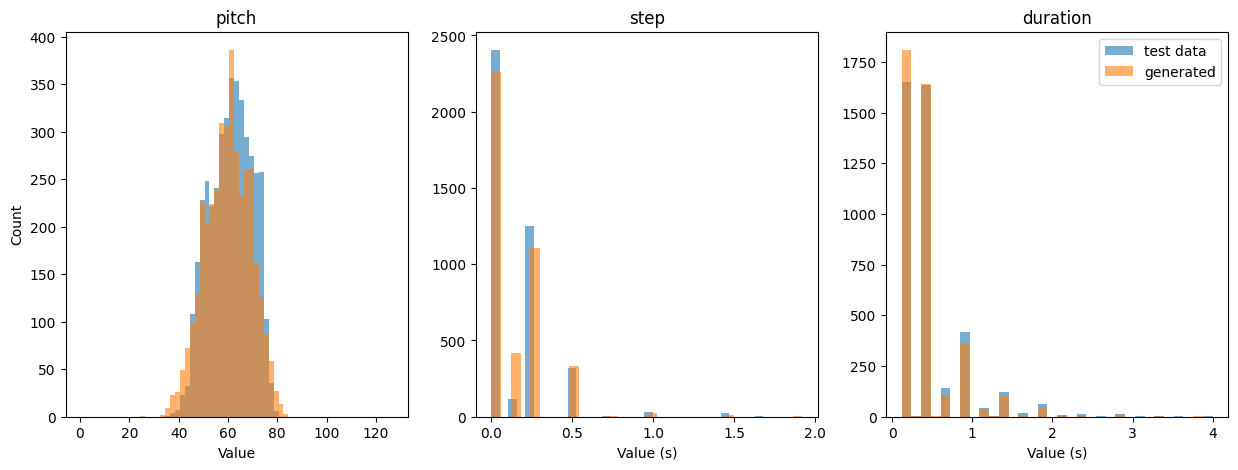

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

import matplotlib.pyplot as plt

all_test_notes = torch.vstack(test_notes_tl).type(torch.float32)
all_test_notes = all_test_notes[:len(all_test_notes)//4]  # to save time, let's not do stats on ALL-all of them, just a quarter

# generate a big batch of fake data. 
# WARNING: this is super slow because our generator only works for batches of one, oops
prompt_len, max_new_tokens = 12, 54          # I just made these numbers up. not great science yet, sorry.
new_notes_list = []
print("Generating new notes...") 
for i, notes in enumerate(tqdm(test_notes_tl, ncols=100)): 
    ptoks = encode(notes[:prompt_len]).unsqueeze(0).to(device)
    # generate more notes, chop off prompt before adding to list of all generated notes
    new_notes_list.append( decode( model.generate(ptoks, max_new_tokens=max_new_tokens)[0].cpu()[prompt_len:] ) )
all_new_notes = torch.vstack(new_notes_list).type(torch.float32)

print(f"# of test notes = {len(all_test_notes)},  # of generated notes = {len(all_new_notes)} --- Close enough!")


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
names = ['pitch', 'step', 'duration']
for i in range(3):
    bins = 32 if i !=0 else 0.5 + 2*np.arange(128//2) 
    ax[i].hist(all_test_notes[:,i].numpy(), bins=bins, label='test data', alpha=0.6)
    ax[i].hist(all_new_notes[:,i].numpy(),  bins=bins, label='generated', alpha=0.6)
    ax[i].set_title(names[i])
    if i==2: ax[i].legend()
    ax[i].set_xlabel('Value'+f'{" (s)" if i>0 else ""}')
    if i==0: ax[i].set_ylabel('Count')
plt.show()

Hey! The generated and test data distributions look prety similar. The generated pitches have a slighly larger spread, which is consistent with what we observe in the generated examples, and may be due to the pitch-shifting in our data augmentation. 

I'm curious why the `step` values seem to be shifted to the right in the generated data; that's a bit "sus" to me.  But, that'll be an investigation for another time.  We need to wrap this up!  

# Summary

TODO: write more...yay. 

If you'd like to run the code from this post, [here it is as a Colab notebook](https://colab.research.google.com/github/drscotthawley/TTTT/blob/main/notebooks/Transformers2-MusicBox-Colab.ipynb).  &nbsp; <a href="https://colab.research.google.com/github/drscotthawley/TTTT/blob/main/notebooks/Transformers2-MusicBox-Colab.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg"
  alt="open with Colab" width="130px"/></a>

# Ideas for Further Exploration {#sec-further}

The following are some ideas for taking this lesson further.
<details><summary>Details</summary>



## Change Hyperparamters / Dataset

I tried a *lot* of hyperparameter tuning already. Now it's your turn.  Maybe even trying WandB's ["Sweeps"](https://docs.wandb.ai/guides/sweeps)feature.  Here's a `config` suggestion [that I used for the MAESTRO dataset](https://wandb.ai/drscotthawley/musicbox-maestro-tutorial?workspace=user-drscotthawley):

In [ ]:
#| code-fold: true
#| code-summary: "Watch out, there's a Monster in this code!"

@dataclass
class LargeConfig:  # "Monster" size model ;-) 
    # model architecture details
    seq_length: int = 128
    batch_size: int = 256
    n_embd:     int = 256     
    n_heads:    int = 16      
    n_blocks:   int = 8       
    dropout:  float = 0.5    
    bias:      bool = False

    # training details
    learning_rate: float = 0.001
    weight_decay:  float = 0.04   # 0.01 is pytorch default
    epochs:          int = 12

    # other handy bookkeeping
    vocab_sizes: tuple = tuple(vocab_sizes)

## Report Individual Parts of the Loss
Currently we're not reporting the contributions of pitch, step, and durations to the loss, separately.  Doing so could be instructive! 


## Improving Generation by Implementing Beam Search

Right now we're just sampling a single token from the predicted probability distribution. If we instead predicted the most likely estimates by looking two or three steps into the future, that could greatly improve our results. Check out "beam search" algorithms. 


## Using Huggingface's `transformers` instead

`trasformers` is a package that is optimized for general applications and would probably outperform the above code in numerous ways. 


## Pitch-Only Estimation

The timing can be the most challenging part. If you take that out and do only pitches (i.e. assume all notes have the same spacing and duration), you may like what you hear. 

## Raw Audio

If you were to instead use raw audio, I'd recommend converting it to spectrograms, treating each column of the spectrogram as a "word vector." However, there'd likely be a lot of "wasted space" so you'd probably want to (invertibly) compress the dimensionality of your "audio-word vectors" via something like [(Residual) Vector Quantization](https://drscotthawley.github.io/blog/posts/2023-06-12-RVQ.html), an [autoencoder](https://drscotthawley.github.io/audio-algebra/given-models.html), or [UMAP](https://umap-learn.readthedocs.io/en/latest/). ...And then you'd need to expand/decode it on the output side to be able to listen. Relatedly, a pretrained sytem like Meta's [EnCodec](https://github.com/facebookresearch/encodec) would likely provide such functions nicely.

# Acknowledgements

* Super huge thanks to [Jeremy Jordan](https://twitter.com/jeremyjordan) for many fruitful discussions as I developed this! Check out [his blog](https://www.jeremyjordan.me/) for many helpful posts, esp. on Transformers, Attention, and many other Machine Learning topics. 

* I referred to [Andrej Karpathy's lesson and codes](https://www.youtube.com/watch?v=kCc8FmEb1nY) frequently when my own code wasn't working to my satisfaction (i.e. all the time).

* Various papers by the Google Magenta team -- the undisputed ML-MIDI experts in my book -- were helpful in figuring out what to do. This lesson was influenced by their tutorial ["Generate Music with an RNN"](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb), which I converted PyTorch. In this lesson, code that wasn't lifted from Karpathy was lifted from that.

* I'm thankful to [Ondřej Cífka](https://github.com/cifkao) for the exchanges that led to my development of Jupyter support for the MIDI player object(s) that he built off Magenta's work. 

* As I included in the Preface, thanks to [Mateusz Modrzejewski](https://twitter.com/mamodrzejewski) for what I took to be a word of encouragement.

* ChatGPT was used extensively for helping with what I'll unapologetically term "annoying formatting bullshit" (with pandas, tqdm, CSS,...), but not for anything more significant. 

# Appendix: Feeding it Christmas Carols 🎄

This is probably a bad idea for so many reasons -- it will be *wayyy* outside the distribution of training data -- but given the time of year, I'ma try it anyway.  

::: {.callout-note}
# Attribution
We're downloading the prompt MIDI files on the fly from [MFiles](https://www.mfiles.co.uk/christmas-music-and-carols.htm).
:::

<!--- comment 
---
# Afterward: Stuff I Probably Should Have Looked at First


BTW, that code is a PyTorch implementation of the 2018 [Music Transformer](https://arxiv.org/abs/1809.04281) paper by Google Brain, the abstract of which includes:

> "Existing approaches for representing relative positional information
in the Transformer modulate attention based on pairwise distance (Shaw et al.,
2018). This is impractical for long sequences such as musical compositions since
their memory complexity for intermediate relative information is quadratic in the
sequence length. We propose an algorithm that reduces their intermediate memory
requirement to linear in the sequence length.
This enables us to demonstrate that a
Transformer with our modified relative attention mechanism can generate minutelong compositions (thousands of steps, four times the length modeled in Oore et al.
(2018)) with compelling structure, generate continuations that coherently elaborate
on a given motif, and in a seq2seq setup generate accompaniments conditioned on
melodies"

....but this notebook is a tutorial, so forgive me if it's 5 years behind SOTA. ;-)

[Here's a nother code for a Pytorch MIDI transformer from 2 years ago](https://github.com/spectraldoy/music-transformer)

https://medium.com/data-science-in-your-pocket/music-generation-using-musictransformer-with-codes-c7be89ba85b1

--->

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

xmas_css = '''
<style>
/* Custom player style */
p { 
  margin: 0; 
  color: #c4c4c4; /* mid-lightness text color for title, intended for dark backgrounds */
}

#section3 midi-player {
  display: block;
  width: inherit;
  margin: 4px;
  margin-bottom: 0;
  color: #d4d4d4; /* Lighter text color for better readability */
}
#section3 midi-player::part(control-panel) {
  background: #004400; /* green background */
  border: 2px solid #888; /* Lightened border color for contrast */
  border-radius: 10px 10px 0 0;
}
#section3 midi-player::part(play-button) {
  color: #ffffff; /* White text for visibility */
  border: 2px solid currentColor;
  background-color: #ff00000; 
  border-radius: 20px;
  transition: all 0.2s;
  content: 'hello';
}
#section3 midi-player::part(play-button):hover {
  color: #a00; 
  background-color: #9fafc9; 
  border-radius: 10px;
}
#section3 midi-player::part(time) {
  font-family: monospace; /* Monospace font for time */
}

/* Custom visualizer style */
#section3 midi-visualizer .piano-roll-visualizer {
  background: #900; /* red background for visualizer */
  border: 2px solid #505050; /* Dark border for subtle appearance */
  border-top: none;
  border-radius: 0 0 10px 10px;
  margin: 4px;
  width: inherit;
  margin-top: 0;
  overflow: auto;
}
#section3 midi-visualizer svg rect.note {
  opacity: 0.9; 
  stroke-width: 1; /* Stroke width for note clarity */
}

/* Different instrument colors */
#section3 midi-visualizer svg rect.note[data-instrument="0"]{
  fill: #00f000; /* Green for Instrument 0 */
  stroke: #444; 
}
#section3 midi-visualizer svg rect.note[data-instrument="2"]{
  fill: #008000; /* Green for Instrument 2 */
  stroke: #444;
}
#section3 midi-visualizer svg rect.note[data-is-drum="true"]{
  fill: #008000; /* Green for drum notes */
  stroke: #bbb;
}
#section3 midi-visualizer svg rect.note.active {
  opacity: 0.9; /* Highlight active notes */
  stroke: #ffffff; /* White stroke for maximum contrast */
  stroke-width: 2; /* Thicker stroke for active notes */
}
</style>
'''

def xmasplayer(notes_tensor, height=400, time_rescale=None, midi_file="/tmp/tmp.mid", title='', styler=general, css=xmas_css):
    "MIDIplayer that writes input tensor to temporary file"
    pm = notes_to_midi(notes_tensor, time_rescale=time_rescale, out_file=midi_file)
    return MIDIPlayer(midi_file, height, styler=partial(styler, css=css), dl=True, title=title)

def christmas_ohno(filename, title="", time_rescale=0.242/0.2880, debug=False):
    url = "https://www.mfiles.co.uk/downloads/"+filename
    !wget -qq -N {url}
    
    notes = midi_file_to_tensor(filename)
    if debug: print("notes = ",notes)
    notes[:,1:] = quantize_times(notes[:,1:]*time_rescale, res_ms=10) # time rescale is mainly to get codebooks to agree
    prompt = notes[:30]
    prompt_tokens = encode(prompt).unsqueeze(0).to(device)
    set_seeds(1)
    notes = decode( model.generate(prompt_tokens, max_new_tokens=new_tokens, temperature=0.9)[0].cpu() )
    return xmasplayer(notes,title=title)

c1 = christmas_ohno("jingle-bells-keyboard.mid", title="Janky Bells")
c2 = christmas_ohno("away-in-a-manger.mid", title="Away in a Mangled", time_rescale=.48/.68)
c3 = christmas_ohno("hark-the-herald-angels-sing.mid", title="Arg the Herald Angels Cringe",time_rescale=.48/.616)
display(c1)
display(c2)
display(c3)

In [ ]:
#| echo: false
#| output: false

# silly stunt for wandb pals
for cp in [c1,c2,c3]:
    wandb.init(project='musicbox-jsb-xmas', config=config)
    wandb.log({'player':wandb.Html(cp.html)})
    wandb.finish()

...yea, not sure what that accomplished, but it was fun to try! 

::: {.callout-tip}
For more holiday-themed Machine Learning instruction, check out ["🎅 Naughty by Numbers:
Classifications at Christmas"](https://hedges.belmont.edu/~shawley/naughty/)!
:::


<center>My official December faculty photo:<br>
**"Happy Holidays from Dr. Hawley and Wedge the Destroyer"**<br>
<img src="images/hawley_wedge.jpeg" width="300px">
</center>

---
Copyright (c) 2023, Scott H. Hawley.  Code is MIT-licensed, text is licensed CC-BY-NC 4.0. 